# DIAL Studies

This code loads the simulated online and offline channels and performs Standard and CDC corrections. The corrected data is then used to further process as a DIAL retrieval.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
from pathlib import Path

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

import fit_polynomial_utils_cloud as fit
import data_organize as dorg

eps = sys.float_info.epsilon

C:\Users\Grant\anaconda3\envs\arsenl-conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Grant\anaconda3\envs\arsenl-conda\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Constants

c = 299792458  # [m/s] speed of light
k_B = 1.380649e-23  # [m^2 kg s-2 K-1]
g_0 = 9.81  # [m s-2] Gravity
M_air = 28.97  # [g/mol] Molar mass of air
R_0 = 8.314459  # [J/mol/K] Universal gas constant
N_A = 6.022e23  # [atoms / mol] Avogadro's number
h = 6.626e-34  # [J s] Planck's constant

L = 9e-3  # [K/km] Temperature lapse rate for Denver
P_0 = 840  # [mbar] Typical absolute pressure for Denver
T_0 = 294.3  # [K] Typical 70 F temperature for Denver
lamb = 828e-9  # [m] laser wavelength

D = 8  # [in] outer diameter of telescope
d = 1.8  # [in] inner diameter of telescope

dt_TCSPC = 250e-12  # [s] native resolution of TCSPC

# Laser specs
P_L = 35e-3 * 8  # [W] average laser power
dt_L = 700e-12  # [s] laser pulse FWHM
f_L = 14.7e3  # [Hz] rep rate

# Receiver specs (at 532 nm)
R_tele = 0.95  # Telescope reflectance
R_M = 0.99  # Folding mirror reflectance
T_L = 0.9  # Standard lens transmittance
mu_F = 0.994  # [m-1] Fiber transmission coefficient
L_F = 2  # [m] Fiber length
T_F = mu_F * L_F  # Fiber transmittance
T_FC = T_L  # Fiber coupler transmittance
T_BS_LG = 0.05  # Beam-splitter low-gain transmittance
T_BS_HG = 0.95  # Beam-splitter high-gain transmittance
T_SBF = 0.9  # Solar background filter transmittance
eta_QE = 0.5  # Detector quantum efficiency
loss = 10  # Unaccounted loss term
tD = 20e-9  # [s] SPAD deadtime

dalt = c * dt_TCSPC / 2  # [m]
alt = np.arange(eps, 1.25e3, dalt)  # [m] target range
xsec = 1e-26  # [m^2]

### Load sim, correct, then perform DIAL calculation

In [3]:
# Load data

# Constants
c = 299792458  # [m/s] speed of light

# Parameters
home = str(Path.home())
load_dir = os.path.join(home, 'OneDrive - UCB-O365', 'ARSENL', 'Experiments', 'Cloud Measurements', 'Sims', 'saved_sims')
# load_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\Digitization Tests\Sims\saved_sims'

fname_off = r'simnum_1_amp_7.92E+07off_nshot1.00E+04_OFF.nc'
fname_on = r'simnum_1_amp_7.92E+07off_nshot1.00E+04_ON.nc'

ds_off = xr.open_dataset(os.path.join(load_dir, fname_off))
ds_on = xr.open_dataset(os.path.join(load_dir, fname_on))

phot_events_off = ds_off.true_time_tag.values
dt_sim = ds_off.dt_sim.values  # [s]
sim_time = ds_off.t_sim_bins.values  # [s]
Nshot = ds_off.sync_index.values[-1] + 1
det_events_off = ds_off.time_tag.values
det_sync_idx_off = ds_off.time_tag_sync_index
phot_sync_idx_off = ds_off.true_time_tag_sync_index
photon_rate_off_shift = ds_off.photon_rate_arr.values
tD = ds_off.dtime.values  # [s] deadtime
window_bnd = ds_off.window_bnd.values  # [m]

phot_events_on = ds_on.true_time_tag.values
det_events_on = ds_on.time_tag.values
det_sync_idx_on = ds_on.time_tag_sync_index
phot_sync_idx_on = ds_on.true_time_tag_sync_index
photon_rate_on_shift = ds_on.photon_rate_arr.values


In [4]:
det_events_ordered_off = []
phot_events_ordered_off = []
det_events_ordered_on = []
phot_events_ordered_on = []
for i in range(Nshot):
    # OFFLINE
    det_idx_off = np.where(np.array(det_sync_idx_off)==i)[0]
    phot_idx_off = np.where(np.array(phot_sync_idx_off)==i)[0]
    if det_idx_off.size == 0:
        det_events_ordered_off.append([])
    else:
        det_events_shot_off = det_events_off[det_idx_off]
        det_events_ordered_off.append(det_events_shot_off)
    if phot_idx_off.size == 0:
        phot_events_ordered_off.append([])
    else:
        phot_events_shot_off = phot_events_off[phot_idx_off]
        phot_events_ordered_off.append(phot_events_shot_off)
    # ONLINE
    det_idx_on = np.where(np.array(det_sync_idx_on)==i)[0]
    phot_idx_on = np.where(np.array(phot_sync_idx_on)==i)[0]
    if det_idx_on.size == 0:
        det_events_ordered_on.append([])
    else:
        det_events_shot_on = det_events_on[det_idx_on]
        det_events_ordered_on.append(det_events_shot_on)
    if phot_idx_on.size == 0:
        phot_events_ordered_on.append([])
    else:
        phot_events_shot_on = phot_events_on[phot_idx_on]
        phot_events_ordered_on.append(phot_events_shot_on)

In [5]:
avg_range = 10

shift_bot = window_bnd[0]  # [m]
shift_top = window_bnd[1]  # [m]

plot_bins = sim_time[::avg_range] + shift_bot/c*2  # [s]

# OFFLINE
n_det_off, bins = np.histogram(det_events_off*dt_sim, bins=plot_bins)
dt = np.diff(bins)[0]
det_flux_off = n_det_off/dt/Nshot

n_phot_off, _ = np.histogram(phot_events_off*dt_sim, bins=plot_bins)
phot_flux_off = n_phot_off/dt/Nshot

# ONLINE
n_det_on, _ = np.histogram(det_events_on*dt_sim, bins=plot_bins)
det_flux_on = n_det_on/dt/Nshot

n_phot_on, _ = np.histogram(phot_events_on*dt_sim, bins=plot_bins)
phot_flux_on = n_phot_on/dt/Nshot

print('Plotting range resolution: {:.2f} m'.format(dt*c/2))

Plotting range resolution: 0.37 m


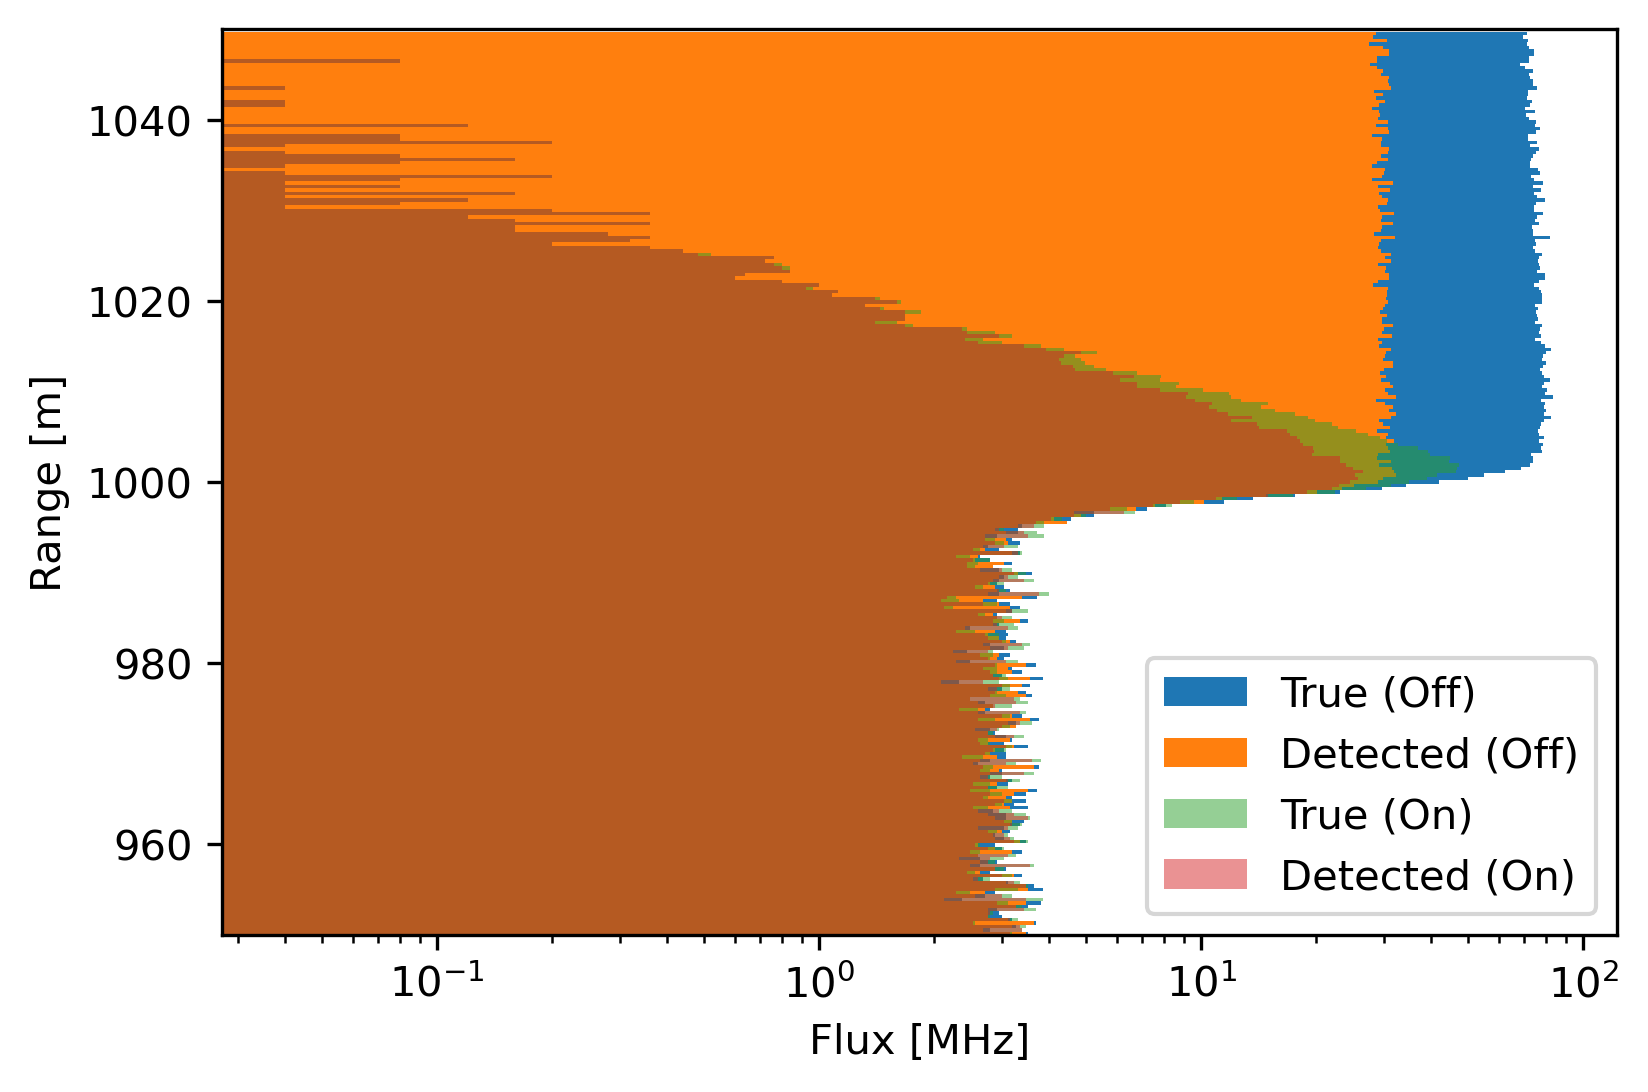

In [6]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.barh((plot_bins[:-1]+dt/2)*c/2, phot_flux_off/1e6, height=dt*c/2, label='True (Off)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, det_flux_off/1e6, height=dt*c/2, label='Detected (Off)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, phot_flux_on/1e6, height=dt*c/2, alpha=0.5, label='True (On)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, det_flux_on/1e6, height=dt*c/2, alpha=0.5, label='Detected (On)')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_ylim([shift_bot, shift_top])
ax.set_xscale('log')
plt.legend()
plt.show()

In [211]:
dR_avg = dt * c / 2  # [m]

meas_conc = 1/2/xsec/dR_avg*np.diff(np.log(det_flux_off/det_flux_on))  # [m-3]
muller_conc = 1/2/xsec/dR_avg*np.diff(np.log((det_flux_off/(1-tD*det_flux_off))/(det_flux_on/(1-tD*det_flux_on))))  # [m-3]
true_conc_theory = 1/2/xsec/dR_avg*np.diff(np.log((photon_rate_off_shift[::avg_range])/(photon_rate_on_shift[::avg_range])))

C:\Users\Grant\AppData\Local\Temp\ipykernel_15608\3014706198.py:3: RuntimeWarning: divide by zero encountered in divide
  meas_conc = 1/2/xsec/dR_avg*np.diff(np.log(det_flux_off/det_flux_on))  # [m-3]
C:\Users\Grant\AppData\Local\Temp\ipykernel_15608\3014706198.py:4: RuntimeWarning: divide by zero encountered in divide
  muller_conc = 1/2/xsec/dR_avg*np.diff(np.log((det_flux_off/(1-tD*det_flux_off))/(det_flux_on/(1-tD*det_flux_on))))  # [m-3]


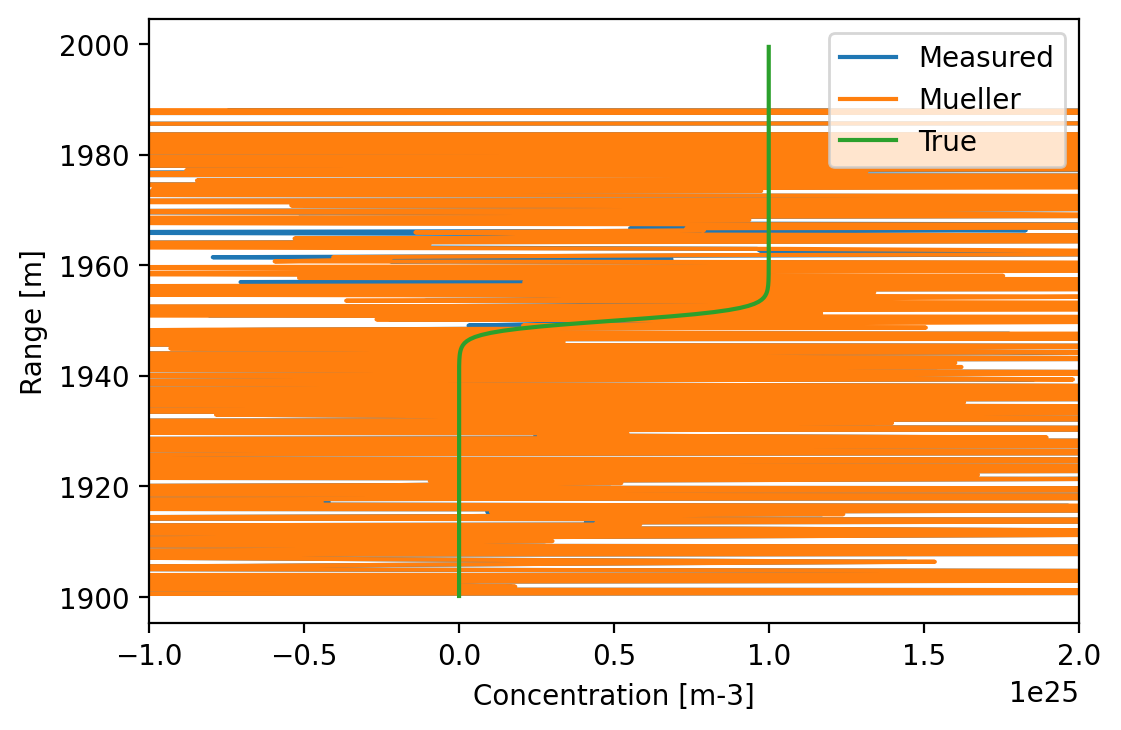

In [212]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(meas_conc, (plot_bins[1:-1])*c/2+shift_bot, label='Measured')
ax.plot(muller_conc, (plot_bins[1:-1])*c/2+shift_bot, label='Mueller')
ax.plot(true_conc_theory, (plot_bins[:-1]+dt/2)*c/2+shift_bot, label='True')
ax.set_xlabel('Concentration [m-3]')
ax.set_ylabel('Range [m]')
ax.set_xlim([-1e25, 2e25])
# ax.set_ylim([980, 1020])
# ax.set_xscale('log')
plt.legend()
plt.show()

In [203]:
t_min = plot_bins[0]  # [s]
t_max = plot_bins[-1]  # [s]
window_bnd = [t_min, t_max]  # [s]

# calculate active fraction histogram
dsamp = 1
intgrl_N = int(len(sim_time)/dsamp)  # number of bins in integral. I usually set this to the number of bins in the histogram for consistency
deadtime = tD  # [s] 

shot_avg = int(10000)
exclude_shots = True

# Check that shot average is divisible by the number of shots
if Nshot % shot_avg != 0:
    print('Change "shot_avg" variable to divisible number!')
    
if type(shot_avg) != int:
    shot_avg = int(shot_avg)
    
num_temporal_bins = Nshot / shot_avg
print('Number of temporal bins: {}'.format(num_temporal_bins))
print('Number of range bins: {}'.format(intgrl_N))

Number of temporal bins: 1.0
Number of range bins: 2669


In [362]:
avg_bins = 400
max_idx = (intgrl_N//avg_bins) * avg_bins
rmndr = intgrl_N - max_idx
print('Remainder range bins per column getting thrown away to average to coarser bins: {}'.format(rmndr))

cnts_curtain_off = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
muller_curtain_off = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
cdc_curtain_off = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
active_ratio_curtain_off = np.zeros((int(num_temporal_bins), intgrl_N))
cnts_curtain_on = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
muller_curtain_on = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
cdc_curtain_on = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
active_ratio_curtain_on = np.zeros((int(num_temporal_bins), intgrl_N))
start = time.time()
for i in range(int(num_temporal_bins)):
    # OFFLINE
    flight_time_off, n_shots, t_det_lst_off = dorg.data_organize(dt_sim, load_dir, fname_off, window_bnd, shot_avg-1, exclude_shots, repeat_num=i+1)
    t_phot_fit_tnsr_off = flight_time_off.values
    n_shots += 1

    active_ratio_hst_off, AF_bin_edges_off = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst_off, n_shots)
    active_ratio_hst_off = active_ratio_hst_off.detach().numpy()
    active_ratio_hst_off[np.where(active_ratio_hst_off==0)[0]] = sys.float_info.min  # if AF=0 for any bin, replace it with small positive value
    active_ratio_curtain_off[i, :] = active_ratio_hst_off
    
    Y_off = np.histogram(t_phot_fit_tnsr_off, bins=AF_bin_edges_off)[0]
    cdc_off = Y_off / active_ratio_hst_off

    binwidth = np.diff(AF_bin_edges_off)[0]
    binwidth_smooth = binwidth * avg_bins
    if i == 0:
        print('Range binwidth: {:.2f} m'.format(binwidth_smooth*c/2))

    # Raw counts
    Y_reshape_off = np.reshape(Y_off[:max_idx], (len(Y_off)//avg_bins, avg_bins))
    Y_smooth_off = np.sum(Y_reshape_off, axis=1)
    # CDC
    cdc_reshape_off = np.reshape(cdc_off[:max_idx], (len(cdc_off)//avg_bins, avg_bins))
    cdc_smooth_cnts_off = np.sum(cdc_reshape_off, axis=1)
    
    cnts_curtain_off[i, :] = Y_smooth_off / n_shots / binwidth_smooth  # [Hz]
    muller_curtain_off[i, :] = cnts_curtain_off[i, :] / (1-cnts_curtain_off[i, :]*deadtime)  # [Hz]
    cdc_curtain_off[i, :] = cdc_smooth_cnts_off / n_shots / binwidth_smooth  # [Hz]
    
    print('Time bin #{} OFFLINE'.format(i))
    
    # ONLINE
    flight_time_on, n_shots, t_det_lst_on = dorg.data_organize(dt_sim, load_dir, fname_on, window_bnd, shot_avg-1, exclude_shots, repeat_num=i+1)
    t_phot_fit_tnsr_on = flight_time_on.values
    n_shots += 1

    active_ratio_hst_on, AF_bin_edges_on = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst_on, n_shots)
    active_ratio_hst_on = active_ratio_hst_on.detach().numpy()
    active_ratio_hst_on[np.where(active_ratio_hst_on==0)[0]] = sys.float_info.min  # if AF=0 for any bin, replace it with small positive value
    active_ratio_curtain_on[i, :] = active_ratio_hst_on
    
    Y_on = np.histogram(t_phot_fit_tnsr_on, bins=AF_bin_edges_on)[0]
    cdc_on = Y_on / active_ratio_hst_on
    
    # Raw counts
    Y_reshape_on = np.reshape(Y_on[:max_idx], (len(Y_on)//avg_bins, avg_bins))
    Y_smooth_on = np.sum(Y_reshape_on, axis=1)
    # CDC
    cdc_reshape_on = np.reshape(cdc_on[:max_idx], (len(cdc_on)//avg_bins, avg_bins))
    cdc_smooth_cnts_on = np.sum(cdc_reshape_on, axis=1)
    
    cnts_curtain_on[i, :] = Y_smooth_on / n_shots / binwidth_smooth  # [Hz]
    muller_curtain_on[i, :] = cnts_curtain_on[i, :] / (1-cnts_curtain_on[i, :]*deadtime)  # [Hz]
    cdc_curtain_on[i, :] = cdc_smooth_cnts_on / n_shots / binwidth_smooth  # [Hz]
    
    print('Time bin #{} ONLINE'.format(i))
    
print('Total time: {:.2f} sec'.format(time.time()-start))
cnts_curtain_off = cnts_curtain_off.T[::-1]
muller_curtain_off = muller_curtain_off.T[::-1]
cdc_curtain_off = cdc_curtain_off.T[::-1]
cnts_curtain_on = cnts_curtain_on.T[::-1]
muller_curtain_on = muller_curtain_on.T[::-1]
cdc_curtain_on = cdc_curtain_on.T[::-1]

Remainder range bins per column getting thrown away to average to coarser bins: 269
Range binwidth: 14.94 m
Time bin #0 OFFLINE
Time bin #0 ONLINE
Total time: 27.52 sec


In [363]:
# set up the truth curtain
dim_range = len(sim_time[::avg_bins][:-1])
curtain_truth_off = np.zeros((intgrl_N//avg_bins, Nshot))
curtain_truth_on = np.zeros((intgrl_N//avg_bins, Nshot))
for i in range(Nshot):    
    # OFFLINE
    n_off, _ = np.histogram((np.array(phot_events_ordered_off[i])*dt_sim), bins=AF_bin_edges_off[::avg_bins])
    curtain_truth_off[:, i] = n_off[::-1]
    
    # ONLINE
    n_on, _ = np.histogram((np.array(phot_events_ordered_on[i])*dt_sim), bins=AF_bin_edges_on[::avg_bins])
    curtain_truth_on[:, i] = n_on[::-1]
    
# OFFLINE
rows_off, cols_off = curtain_truth_off.shape
curtain_truth_off = curtain_truth_off.reshape(rows_off, cols_off//shot_avg, shot_avg).sum(axis=2)
curtain_truth_flux_off = curtain_truth_off / n_shots / binwidth_smooth

# ONLINE
rows_on, cols_on = curtain_truth_on.shape
curtain_truth_on = curtain_truth_on.reshape(rows_on, cols_on//shot_avg, shot_avg).sum(axis=2)
curtain_truth_flux_on = curtain_truth_on / n_shots / binwidth_smooth

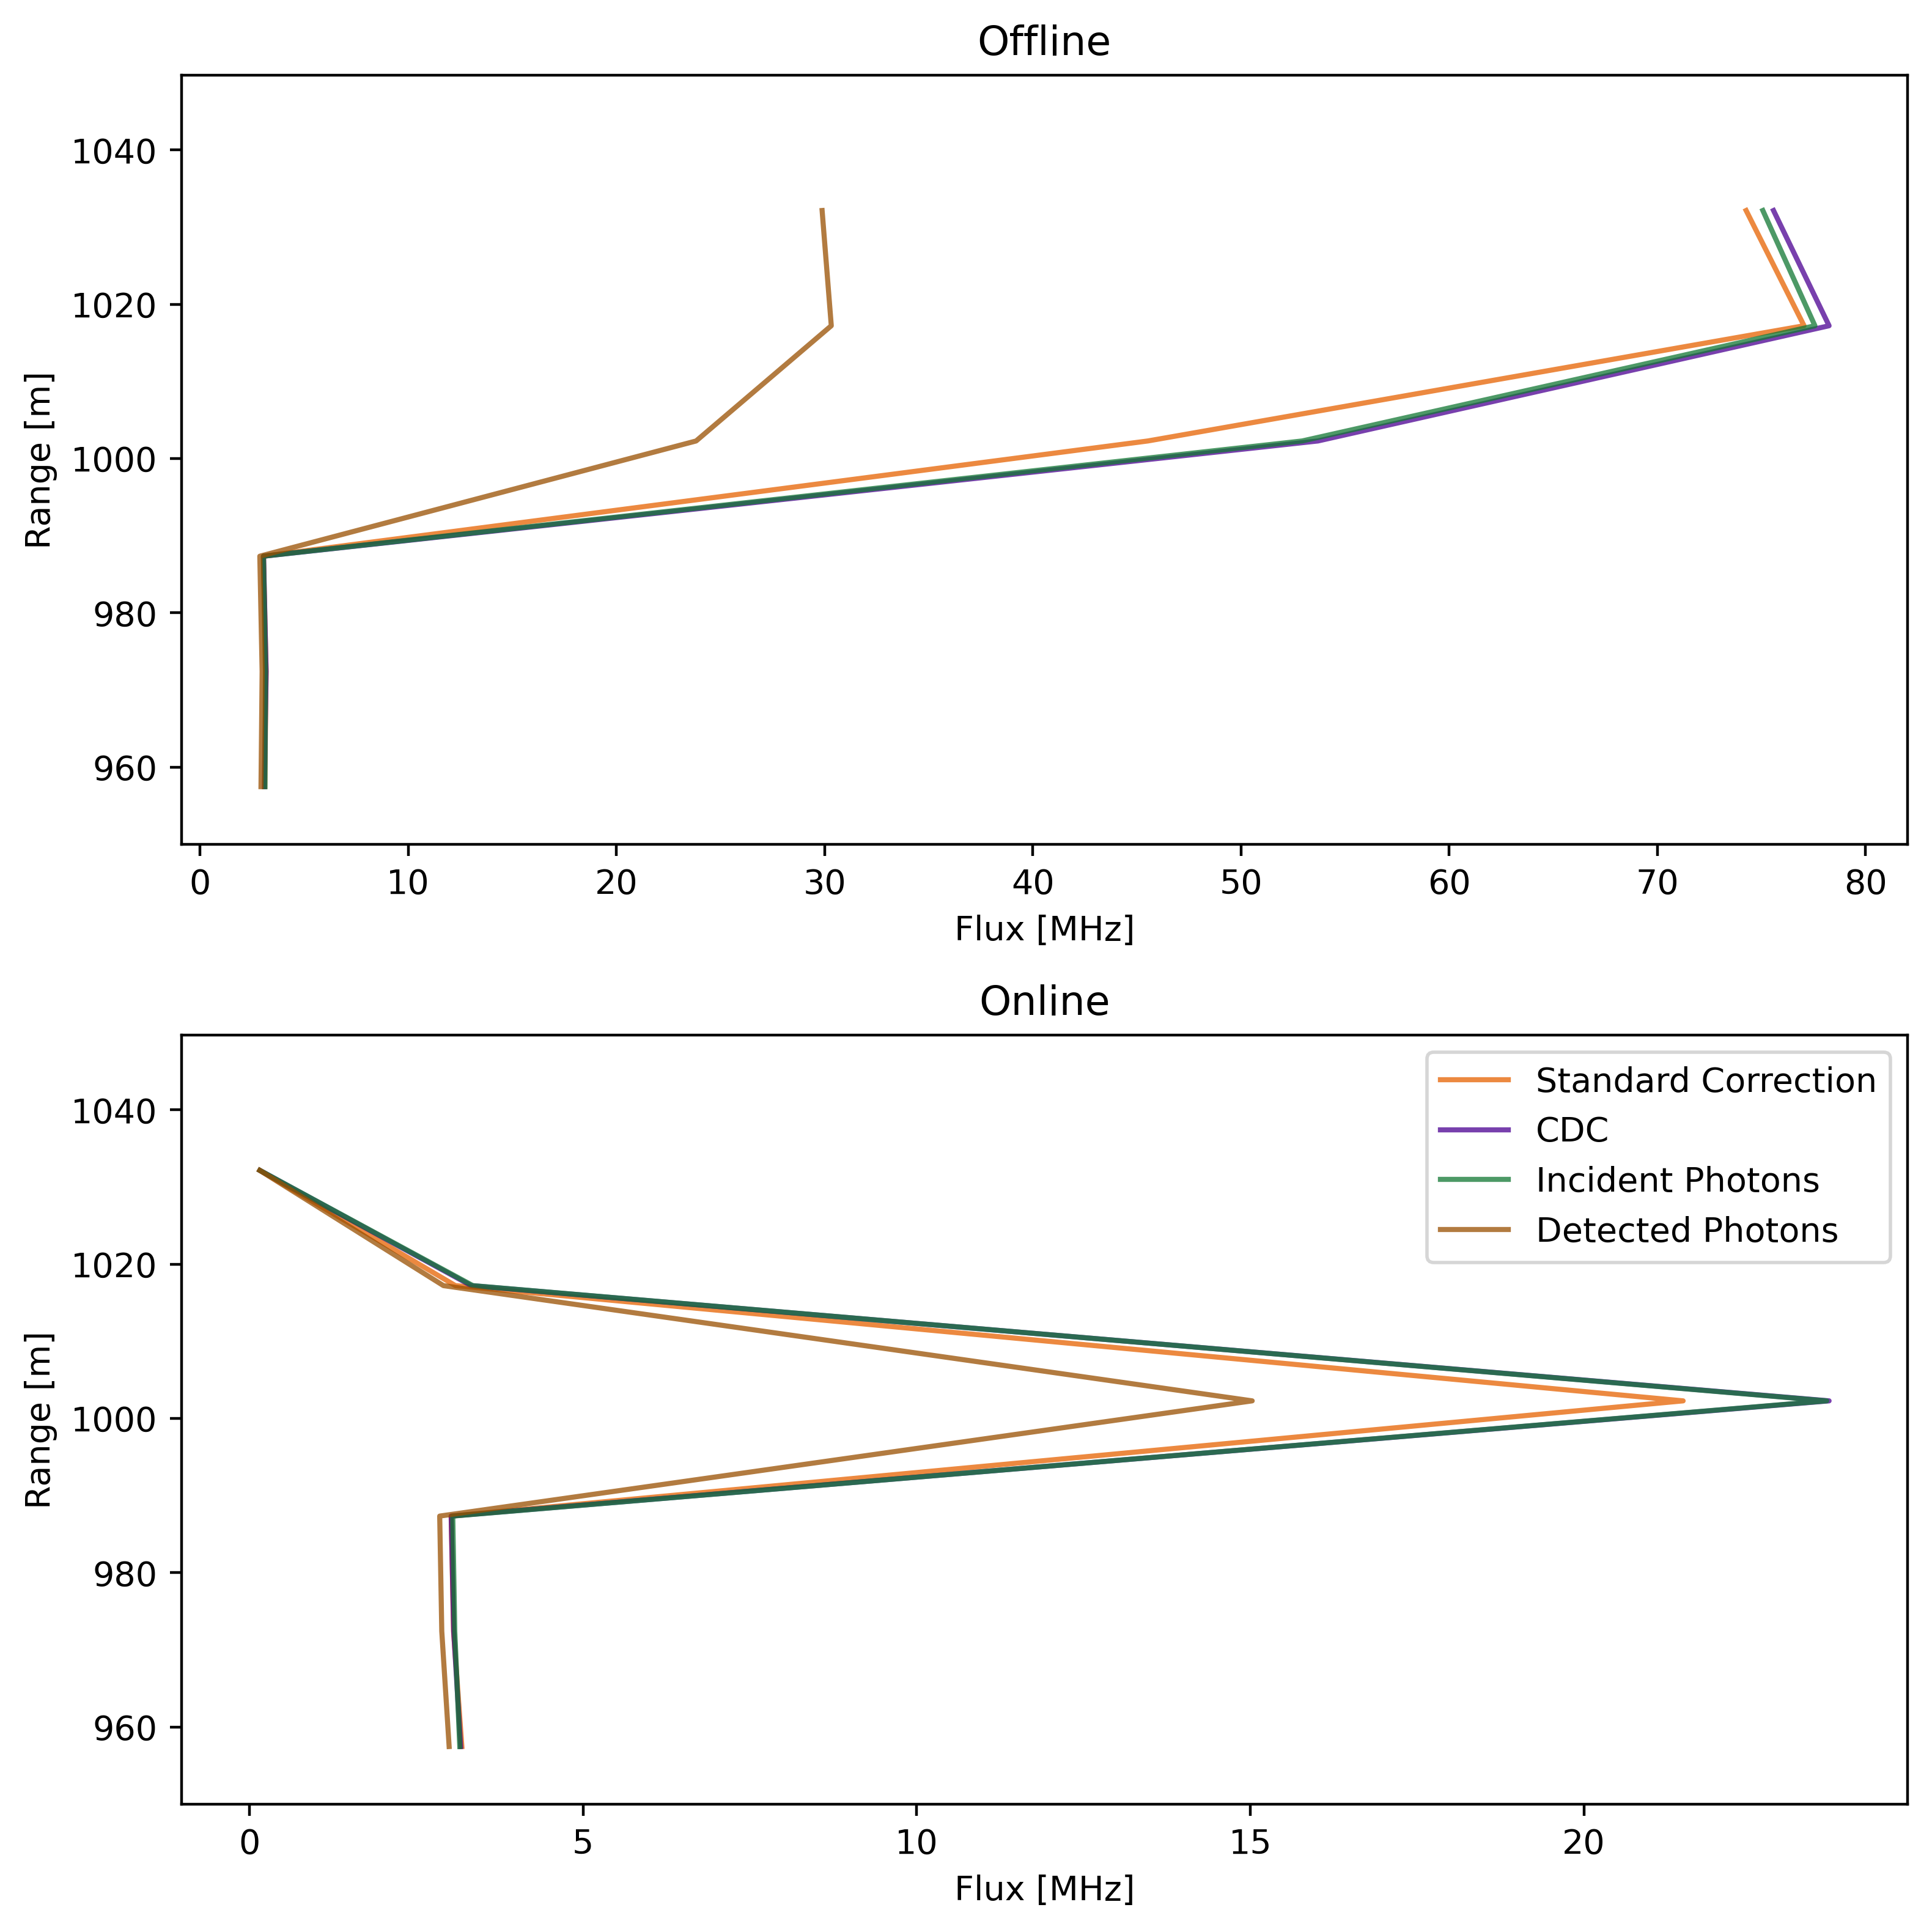

In [364]:
t_plot = np.arange(window_bnd[0]+binwidth_smooth/2, window_bnd[1]-binwidth_smooth/2, binwidth_smooth)
range_plot = t_plot * c / 2  # [m]

fig = plt.figure(dpi=400, figsize=(8, 8))

# OFFLINE
ax1 = fig.add_subplot(211)
ax1.plot(muller_curtain_off[:, 0][::-1]/1e6, range_plot, label='Standard Correction', color='#E66100', alpha=0.75)
ax1.plot(cdc_curtain_off[:, 0][::-1]/1e6, range_plot, label='CDC', color='#4B0092', alpha=0.75)
ax1.plot(curtain_truth_flux_off[:, 0][::-1]/1e6, range_plot, label='Incident Photons', color='#117733', alpha=0.75)
ax1.plot(cnts_curtain_off[:, 0][::-1]/1e6, range_plot, label='Detected Photons', color='#994F00', alpha=0.75)
ax1.set_ylabel('Range [m]')
ax1.set_xlabel('Flux [MHz]')
ax1.set_ylim([window_bnd[0]*c/2, window_bnd[1]*c/2])
ax1.set_title('Offline')

# ONLINE
ax2 = fig.add_subplot(212)
ax2.plot(muller_curtain_on[:, 0][::-1]/1e6, range_plot, label='Standard Correction', color='#E66100', alpha=0.75)
ax2.plot(cdc_curtain_on[:, 0][::-1]/1e6, range_plot, label='CDC', color='#4B0092', alpha=0.75)
ax2.plot(curtain_truth_flux_on[:, 0][::-1]/1e6, range_plot, label='Incident Photons', color='#117733', alpha=0.75)
ax2.plot(cnts_curtain_on[:, 0][::-1]/1e6, range_plot, label='Detected Photons', color='#994F00', alpha=0.75)
ax2.set_ylabel('Range [m]')
ax2.set_xlabel('Flux [MHz]')
ax2.set_ylim([window_bnd[0]*c/2, window_bnd[1]*c/2])
ax2.set_title('Online')

plt.legend()
plt.tight_layout()
plt.show()

In [365]:
dR_avg = binwidth_smooth * c / 2  # [m]

meas_conc = 1/2/xsec/dR_avg*np.diff(np.log(cnts_curtain_off[::-1]/cnts_curtain_on[::-1]).T)[0]  # [m-3]
muller_conc = 1/2/xsec/dR_avg*np.diff(np.log((cnts_curtain_off[::-1]/(1-tD*cnts_curtain_off[::-1]))/(cnts_curtain_on[::-1]/(1-tD*cnts_curtain_on[::-1]))).T)[0]  # [m-3]
cdc_conc = 1/2/xsec/dR_avg*np.diff(np.log(cdc_curtain_off[::-1]/cdc_curtain_on[::-1]).T)[0]
incident_conc = 1/2/xsec/dR_avg*np.diff(np.log((curtain_truth_flux_off[::-1])/(curtain_truth_flux_on[::-1])).T)[0]

if avg_bins%2 != 0:
    print("Pick 'avg_bins' variable that is even!")
true_dR_avg = (dt/avg_range) * c / 2  # [m]
# true_conc_theory_fine = 1/2/xsec/true_dR_avg*np.diff(np.log((photon_rate_off_shift)/(photon_rate_on_shift)))
# true_conc_theory_reshape = np.reshape(true_conc_theory_fine[int(avg_bins/2):max_idx-int(avg_bins/2)], (len(true_conc_theory_fine)//avg_bins-1, avg_bins))
# true_conc_theory_smooth = np.mean(true_conc_theory_reshape, axis=1)
true_conc_theory_fine = 1/2/xsec/true_dR_avg*np.diff(np.log((photon_rate_off_shift)/(photon_rate_on_shift)))
true_conc_theory_reshape = np.reshape(true_conc_theory_fine[:max_idx], (len(true_conc_theory_fine)//avg_bins, avg_bins))
true_conc_theory_smooth = np.mean(true_conc_theory_reshape, axis=1)

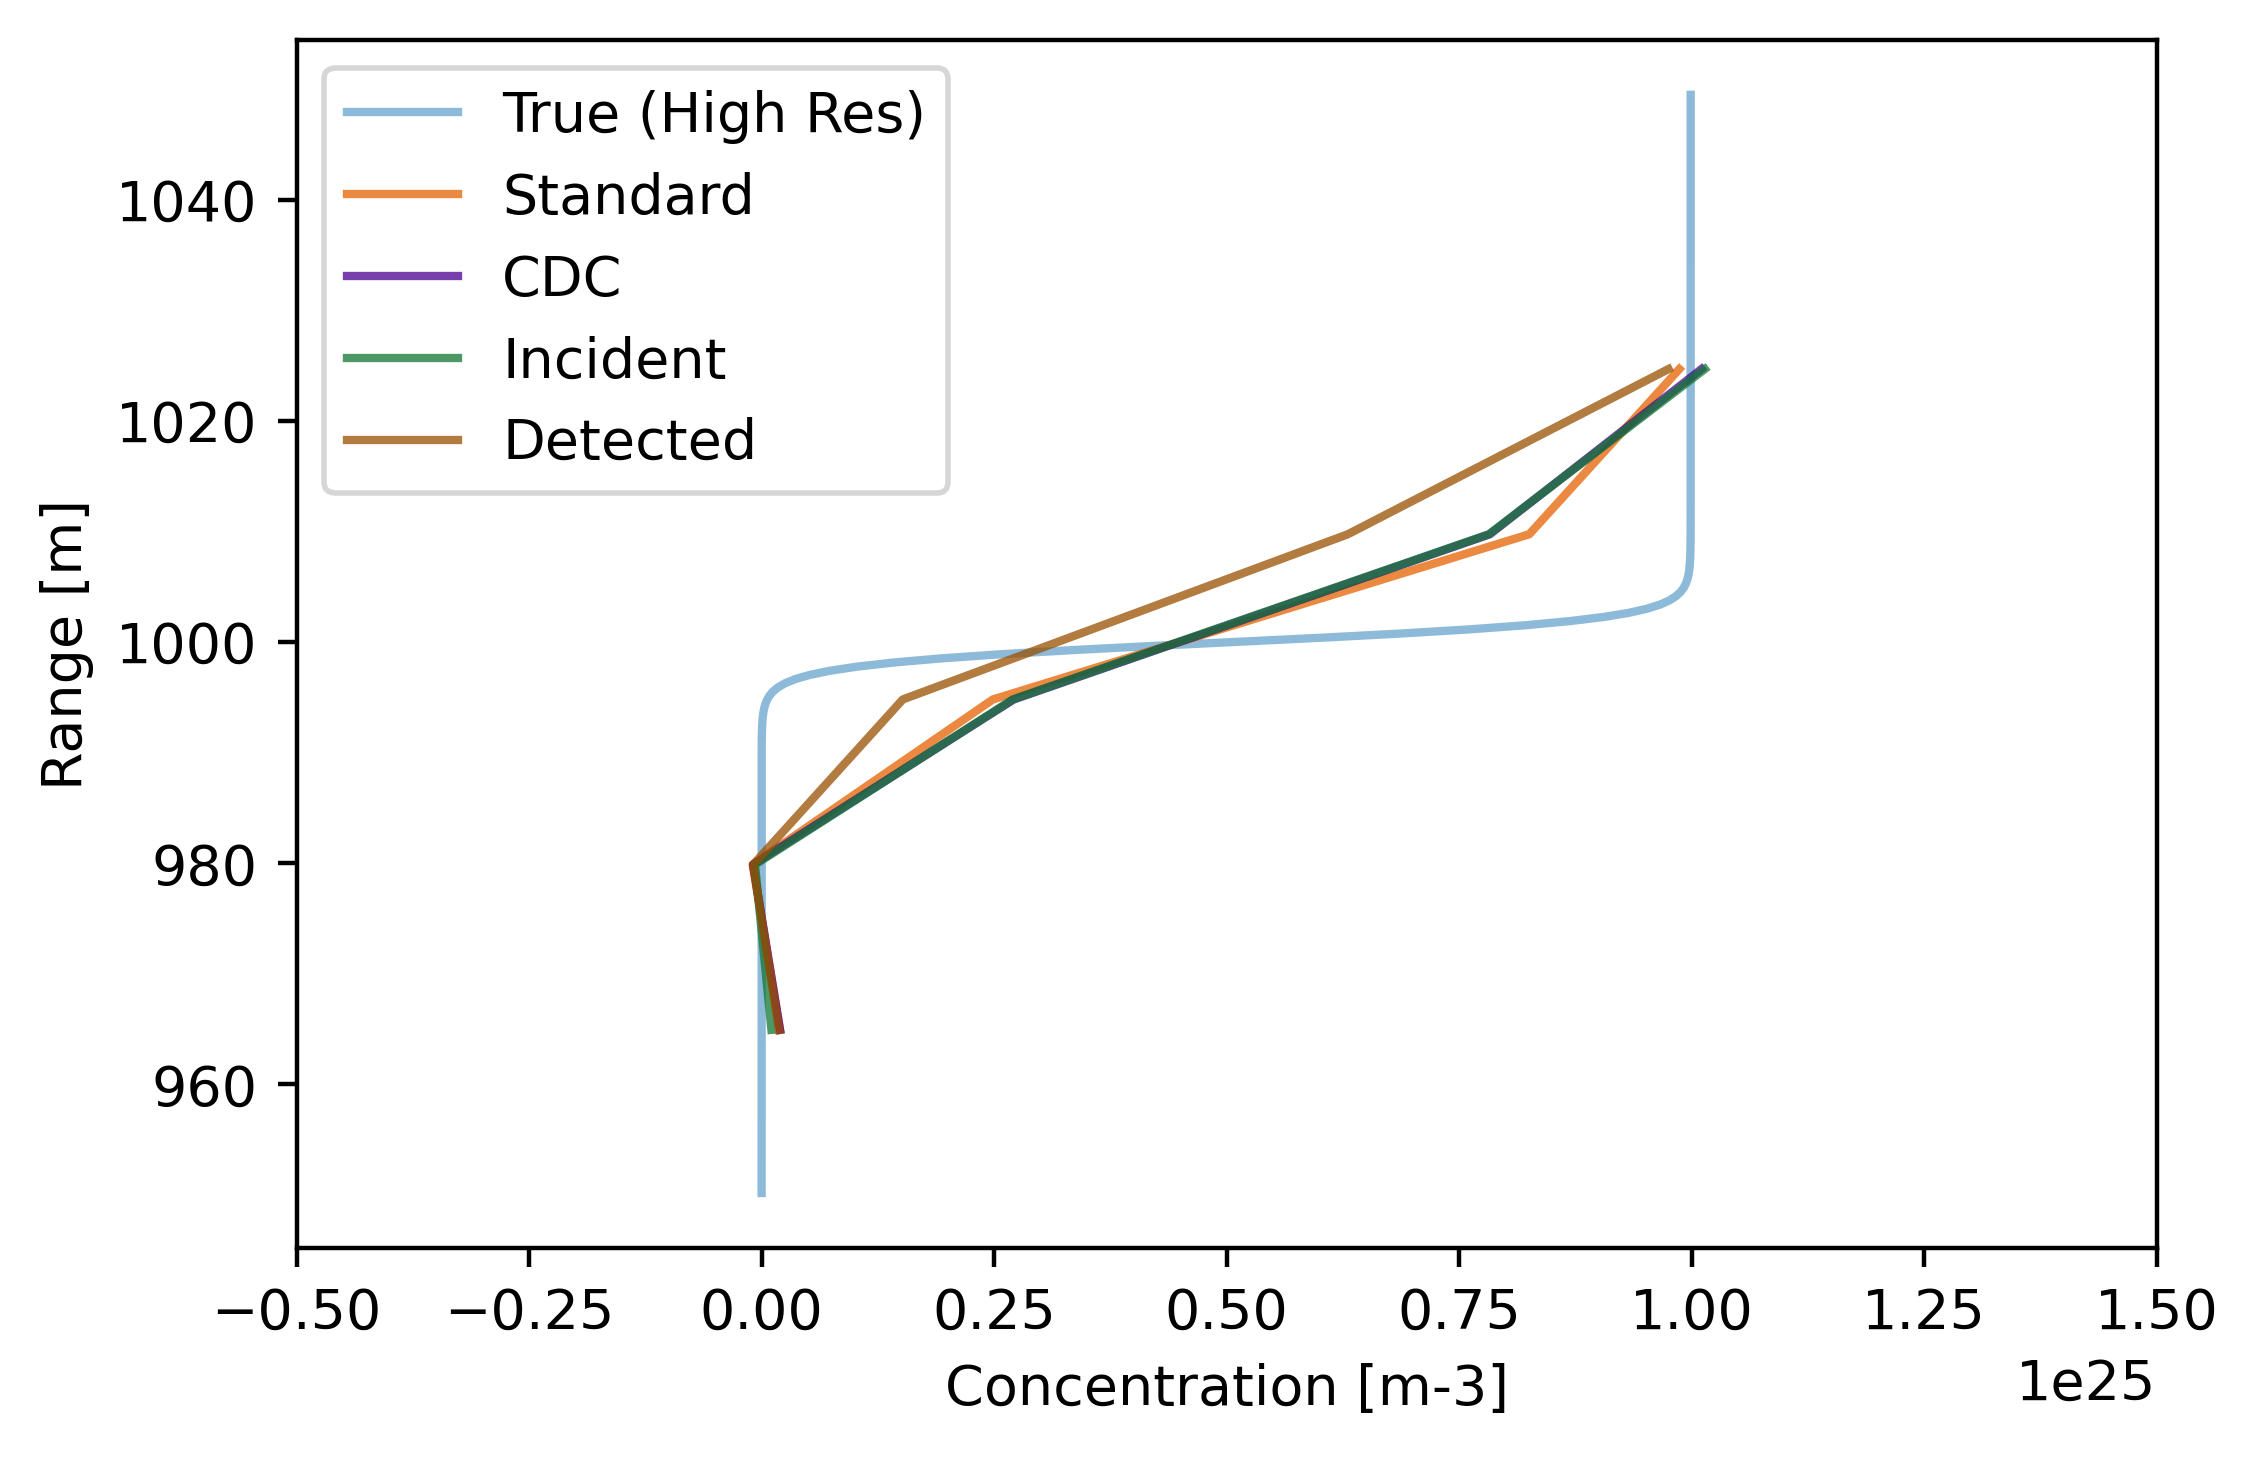

In [366]:
range_plot_DIAL = range_plot[:-1] + np.diff(range_plot)[0]/2

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
ax.plot(true_conc_theory, (plot_bins[:-1]+dt/2)*c/2, label='True (High Res)', alpha=0.5)
ax.plot(muller_conc, range_plot_DIAL, label='Standard', color='#E66100', alpha=0.75)
ax.plot(cdc_conc, range_plot_DIAL, label='CDC', color='#4B0092', alpha=0.75)
ax.plot(incident_conc, range_plot_DIAL, label='Incident', color='#117733', alpha=0.75)
ax.plot(meas_conc, range_plot_DIAL, label='Detected', color='#994F00', alpha=0.75)
# ax.plot(true_conc_theory_smooth[:2], range_plot_DIAL, label='True (Low Res)')
ax.set_xlabel('Concentration [m-3]')
ax.set_ylabel('Range [m]')
ax.set_xlim([-0.5e25, 1.5e25])
# ax.set_ylim([990, 1020])
# ax.set_xscale('log')
plt.legend()
plt.show()

In [367]:
print('standard: {}'.format(muller_conc))
print('cdc: {}'.format(cdc_conc))
print('incident: {}'.format(incident_conc))

print('Errors:\n')
print('standard: {} %'.format(np.abs(incident_conc-muller_conc)/incident_conc*100))
print('cdc: {} %'.format(np.abs(incident_conc-cdc_conc)/incident_conc*100))

standard: [ 1.98787291e+23 -9.67101866e+22  2.48689699e+24  8.25437134e+24
  9.86801242e+24]
cdc: [ 1.97824446e+23 -9.12231475e+22  2.71132840e+24  7.83067164e+24
  1.01066962e+25]
incident: [ 1.05529617e+23 -7.12936258e+22  2.69961018e+24  7.81996388e+24
  1.01418327e+25]
Errors:

standard: [ 88.3710912  -35.65053741   7.87940379   5.55510824   2.69990941] %
cdc: [ 87.45869871 -27.95414246   0.4340709    0.13692845   0.34645095] %
